#**U-Net: Convolutional Networks for Biomedical Image Segmentation**

Vinayak Gupta, 21st May 2021

In this project, I have implemented the U-Net Architecture - a model which takes in a image as input(neuronal structures in electron microscopic stacks) and gives the segmented image of the input image as output.



**U-Net Research Paper** 

The information which I am sharing is mostly from this paper. So if you want a very good understanding of the model, you can have a look at the paper [link text](https://arxiv.org/pdf/1505.04597.pdf)



**Dataset Download** 

I have added the train images and segmentated images and also the test input images. The test labels are not available since they are kept secret [link text](https://drive.google.com/drive/folders/1OWcrg0fSsm-vtoeJpeXOJ_VRTgf3JWsf?usp=sharing)



**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [ ]:
!pip install elasticdeform

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
from torchvision.utils import save_image
import glob
import math 
from sklearn.model_selection import train_test_split
import gc
import time
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import elasticdeform
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

path = "/content/drive/MyDrive/U-Net_DataSet"
batch_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#**Biomedical Segmentation**

#**Loading the Data**

In the class Dataload I am loading the images from the google drive linked above. The images and the corresponding labels are loaded into the train_dataset

In [ ]:
class Dataload(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.train_volumes = []
        self.train_labels = []
        self.train_volumes = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_DataSet/train-volume", '*.jpg')))
        self.train_labels = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_DataSet/train-labels", '*.jpg')))

    def __len__(self):
      return len(self.train_volumes)

    def __getitem__(self, index):
        img = Image.open(self.train_volumes[index]).convert('L')             # 'L' converts it into grayscale image         
        label = Image.open(self.train_labels[index]).convert('L')
        img = self.transform(img)
        label = self.transform(label)
        return img, label

transforms = transforms.Compose([
                                transforms.ToTensor(),
                               ])



train_dataset = Dataload(path, transforms)

#**U-Net Architecture**


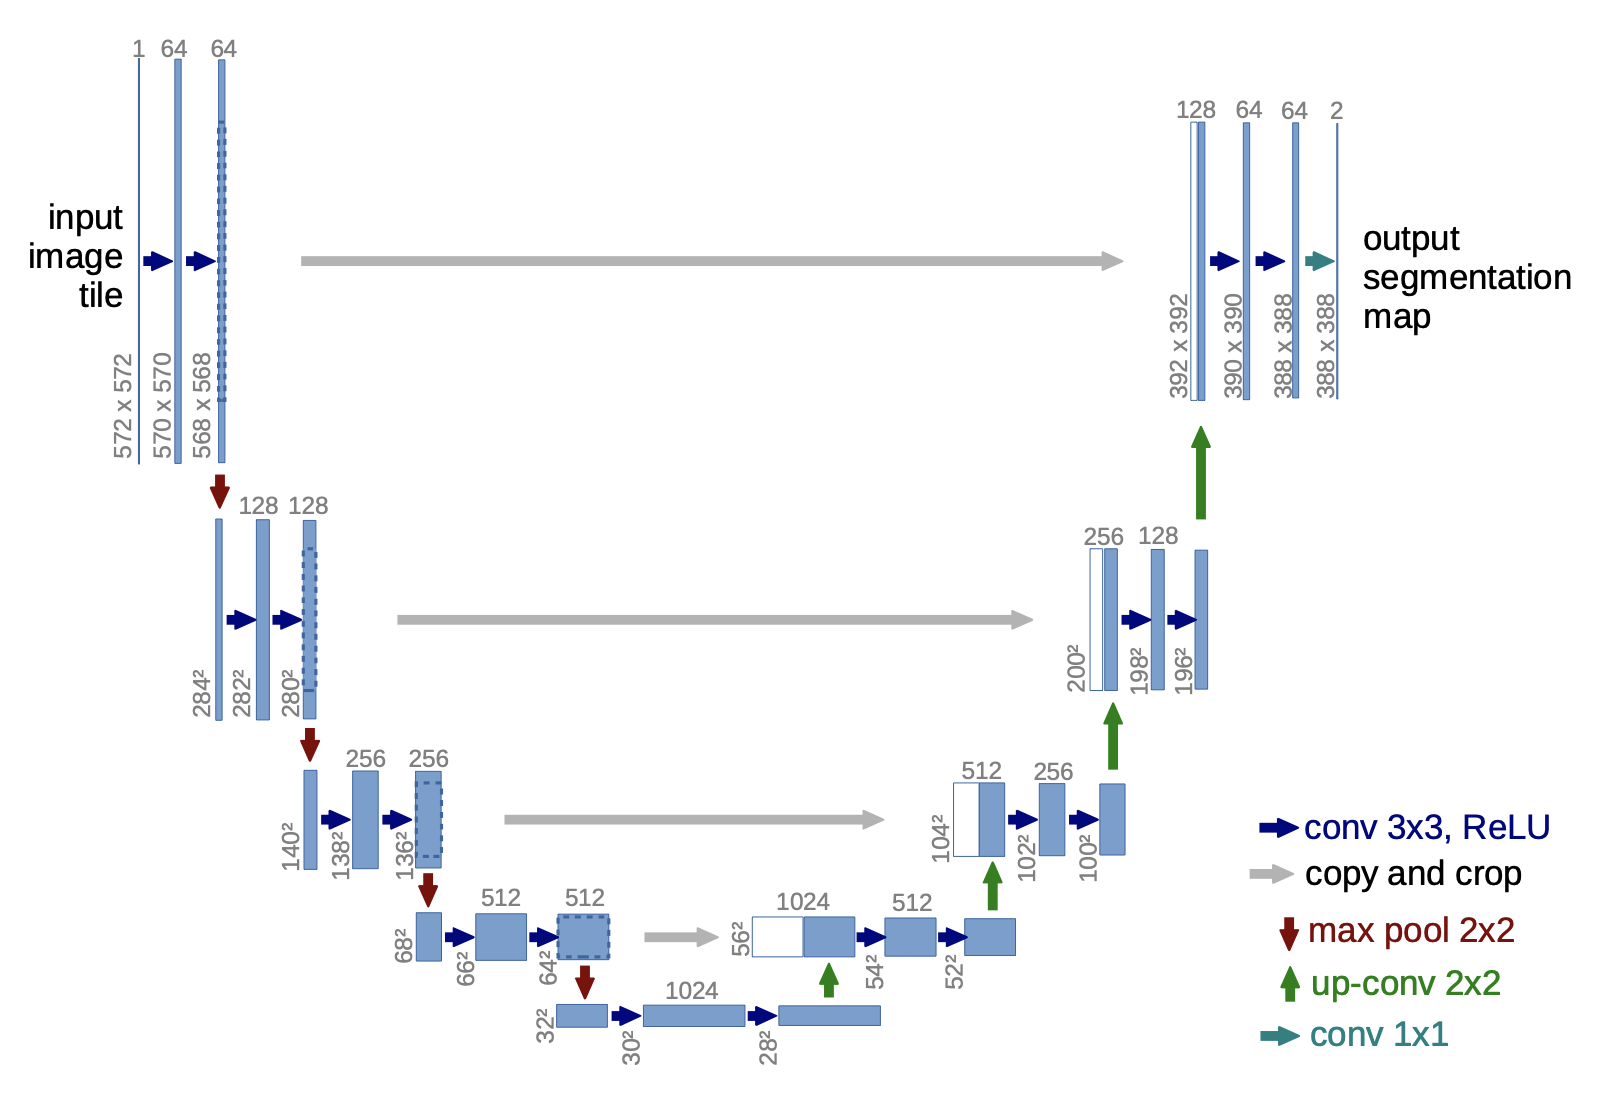

**Encoder** : 
This model is made up of two parts. The first half is the encoder - a contracting path to capture context which basically collects the information on what is present in the image. For example if you show an Image of a cat the encoder part is able to identify that there is a cat in the image but it can't identify where the cat is present in the image since the localization information(positional information) is lost.

**Decoder** : 
This is where the second part of the architecture comes in - the symmetric expanding path that enables precise localization. Here instead of maxpooling layers we use upsampling layers which increase the size of the feature map which increase the resolution of the image. In order to localize, high resolution features from the contracting path are combined with the upsampled output. A successive convolution layer can then learn to assemble a more precise output based on this information.

**Normalisation** : I have implemented Group Normalisation. You can learn more about that in [link text](https://arxiv.org/pdf/1809.03783.pdf). You can checkout the pytorch implementation here [link text](https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html)

**Initialisation of weights of NN** : As given in the paper, I have initialised weights using a Gaussian distribution with a standard deviation of sqrt(2/N), where N denotes the number of incoming nodes of one neuron. 
E.g. for a 3x3 convolution and 64 feature channels in the previous layer N =9·64=576.

**Concatenation of feature maps** :  After every upsampling, we are concatenating the feature map with the corresponding feature map in the contracting path. This is depicted by the gray arrows at the top

**Note** : I have used padding = 'same' in my case, since both the input and output images have same dimension. We need to apply padding so that we do not lose the pixels. Since we have applied padding, we don't need to crop the image while concatenating


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv1.weight, mean=0.0, std=np.sqrt(2/(3*3*64)))
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=np.sqrt(2/(3*3*64)))
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=np.sqrt(2/(3*3*128)))
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv4.weight, mean=0.0, std=np.sqrt(2/(3*3*128)))
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv5.weight, mean=0.0, std=np.sqrt(2/(3*3*256)))
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv6.weight, mean=0.0, std=np.sqrt(2/(3*3*256)))
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv7 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv7.weight, mean=0.0, std=np.sqrt(2/(3*3*512)))
        self.conv8 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv8.weight, mean=0.0, std=np.sqrt(2/(3*3*512)))
        self.maxpool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv9.weight, mean=0.0, std=np.sqrt(2/(3*3*1024)))
        self.conv10 = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=np.sqrt(2/(3*3*1024)))
        self.upconv1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv1.weight, mean=0.0, std=np.sqrt(2/(2*2*512)))
        self.conv11 = nn.Conv2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv11.weight, mean=0.0, std=np.sqrt(2/(3*3*512)))
        self.conv12 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv12.weight, mean=0.0, std=np.sqrt(2/(3*3*512)))
        self.upconv2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv2.weight, mean=0.0, std=np.sqrt(2/(2*2*256)))
        self.conv13 = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv13.weight, mean=0.0, std=np.sqrt(2/(3*3*256)))
        self.conv14 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv14.weight, mean=0.0, std=np.sqrt(2/(3*3*256)))
        self.upconv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv3.weight, mean=0.0, std=np.sqrt(2/(2*2*128)))
        self.conv15 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv15.weight, mean=0.0, std=np.sqrt(2/(3*3*128)))
        self.conv16 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv16.weight, mean=0.0, std=np.sqrt(2/(3*3*128)))
        self.upconv4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv4.weight, mean=0.0, std=np.sqrt(2/(2*2*64)))
        self.conv17 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv17.weight, mean=0.0, std=np.sqrt(2/(3*3*64)))
        self.conv18 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv18.weight, mean=0.0, std=np.sqrt(2/(3*3*64)))
        self.conv19 = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1, stride = 1, padding = 0)
        nn.init.normal_(self.conv19.weight, mean=0.0, std=np.sqrt(2/(1*1*1)))
        self.relu = nn.ReLU()
        self.gn1 = nn.GroupNorm(16, 64)
        self.gn2 = nn.GroupNorm(16, 128)
        self.gn3 = nn.GroupNorm(16, 256)
        self.gn4 = nn.GroupNorm(16, 512)
        self.gn5 = nn.GroupNorm(16, 1024)
        self.dropout = nn.Dropout(0.5)
        self.dropout1 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.gn1(x)
        x = self.relu(x)
        out1 = x
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.gn2(x)
        x = self.relu(x)
        out2 = x
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.gn3(x)
        x = self.relu(x)
        out3 = x
        x = self.maxpool3(x)
        x = self.dropout(x)
        x = self.conv7(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.gn4(x)
        x = self.relu(x)
        out4 = x
        x = self.maxpool4(x)
        x = self.dropout(x)
        x = self.conv9(x)
        x = self.gn5(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.gn5(x)
        x = self.relu(x)
        x = self.upconv1(x)
        x = torch.cat((x, out4), 1)
        x = self.dropout(x)
        x = self.conv11(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.conv12(x)
        x = self.gn4(x)
        x = self.relu(x)
        x = self.upconv2(x)
        x = torch.cat((x, out3), 1)
        x = self.dropout(x)
        x = self.conv13(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.conv14(x)
        x = self.gn3(x)
        x = self.relu(x)
        x = self.upconv3(x)
        x = torch.cat((x, out2), 1)
        x = self.dropout(x)
        x = self.conv15(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.conv16(x)
        x = self.gn2(x)
        x = self.relu(x)
        x = self.upconv4(x)
        x = torch.cat((x, out1), 1)
        x = self.dropout(x)
        x = self.conv17(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv18(x)
        x = self.gn1(x)
        x = self.relu(x)
        x = self.conv19(x)

        return x

model = UNet()

In [ ]:
def make_tensor(tensor):
  if torch.cuda.is_available():
    return torch.cuda.FloatTensor(tensor)
  else:
    return torch.FloatTensor(tensor)

def get_model_summary(model, input_tensor_shape):
    summary(model.to(device), input_tensor_shape)
get_model_summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
         GroupNorm-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
         GroupNorm-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         MaxPool2d-7         [-1, 64, 256, 256]               0
           Dropout-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
        GroupNorm-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
        GroupNorm-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

#**Data Augmentation**


We are given only 30 train images. This is a very low dataset to train on. So we apply elastic deformation to the images and increase the datasize. We can increase the dataset size by how much ever we want. I have increased it to 450 by applying random elastic deformations to the 30 original images 14 times(30*14 + 30)

I have used the elastic deform library given here [link text](https://pypi.org/project/elasticdeform/) You can read more about it in the link given.



I am saving the Images in a new folder. Feel free to change the directory as you wish. While saving the image, I am converting the numpy array to tensor array.

In [ ]:
for j in range(1,15):
    for i in range(30):
        X = train_dataset[i][0].numpy()              # Converting the tensor to numpy since we need to input a np array
        Y = train_dataset[i][1].numpy()              # Converting the tensor to numpy since we need to input a np array
        [X_deformed, Y_deformed] = elasticdeform.deform_random_grid([X, Y], sigma=10, points=3, axis = (1,2))        # The value of sigma and the dimension of the grid are given the U-Net paper
        save_image(torch.from_numpy(X_deformed.clip(0, 1).astype('float64')), f"/content/drive/MyDrive/U-Net_Train_Deformed/train-volume/train-volume-{i+1+(j*30)}.jpg")     
        save_image(torch.from_numpy(Y_deformed.clip(0, 1).astype('float64')), f"/content/drive/MyDrive/U-Net_Train_Deformed/train-labels/train-labels-{i+1+(j*30)}.jpg")

After elastic deformation, now I am loading the entire dataset into a dataloader for training. I am diving the dataset into train and val set with ratio 80:20

In [ ]:
class Dataload(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.train_volumes = []
        self.train_labels = []
        self.train_volumes = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_Train_Deformed/train-volume", '*.jpg')))
        self.train_labels = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_Train_Deformed/train-labels", '*.jpg')))

    def __len__(self):
      return len(self.train_volumes)

    def __getitem__(self, index):
        img = Image.open(self.train_volumes[index]).convert('L')
        label = Image.open(self.train_labels[index]).convert('L')
        img = self.transform(img)
        label = self.transform(label)
        return img, label

transform = transforms.Compose([
                                transforms.ToTensor()
                               ])


train_dataset = Dataload(path, transform)
train_set, val_set = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers = 2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers = 2)

I am loading the test data set for testing. I don't have the corresponding segmentation map of test images but we can still compare the results with the test image 




In [ ]:
class Dataload_Test(Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.test_volumes = []
        self.test_volumes = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_DataSet/test-volume", '*.jpg')))

    def __len__(self):
      return len(self.test_volumes)

    def __getitem__(self, index):
        img = Image.open(self.test_volumes[index]).convert('L')
        img = self.transform(img)
        return img

transforms = transforms.Compose([
                                transforms.ToTensor(),
                               ])

test_dataset = Dataload_Test(transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)

#**Training**

In [ ]:
epoch_train_losses = []              # Defining an empty list to store the epoch losses
epoch_val_losses = []             
accu_train_epoch = []                # Defining an empty list to store the accuracy per epoch
accu_val_epoch = []

I am using a Binary Cross entropy loss since for every image the output should be either 1 or 0. 0 refers to black which corresponds the segmentation/borders of the cell and 1 refers to white which corresponds to the cell.

The reason why we use IoU score instead of normal Pixel Accuracy is because of the class imbalance. For example, if the model full white, still then the pixel accuracy would be around 80% which looks good but it is definitely bad. So we use better metrics like IoU and Dice Coefficient to properly evaluate our metric. To know more about IoU and Dice Coefficient and it's advantage over pixel accuracy, read this article [link text](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)

In [ ]:
batch_size = 1
epochs = 1
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss = nn.BCEWithLogitsLoss()                                         
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr, momentum = 0.99)

def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = output.data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

def train(model, dataset, optimizer, criterion, device):

    train_loss_batch = []
    accu_train_batch = []
    model.train()
    for idx,(images, labels) in enumerate(dataset):
      images = images.to(device)
      labels = labels.to(device)

      #Forward Pass
      output = model(make_tensor(images))
      torch.clip(output, 0.0025, 0.9975)            # I am clipping the output because if it becomes 0 or 1 then there is a chance that loss function can explode
      labels = torch.round(labels)                           # Rounding of the image pixel values to 0 or 1 since some of them had values like 0.001, 0.998 etc
      train_loss = loss(output,labels)
      train_loss_batch.append(train_loss)
      output = torch.round(output)
      acc = iou_score(output, labels)
      accu_train_batch.append(acc)
      print(f"Batch: {idx + 1}   Train Loss: {train_loss}   Accuracy: {acc}")
      # Backward
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
    epoch_train_losses.append(sum(train_loss_batch)/360)
    accu_train_epoch.append(sum(accu_train_batch)/360)
    print(f"Train Epoch Loss: {sum(train_loss_batch)/360}   Train Epoch Accuracy: {sum(accu_train_batch)/360}")

def eval(model, dataset, criterion, device):

    val_loss_batch = []
    accu_val_batch = []
    model.eval()
    for idx,(images, labels) in enumerate(dataset):
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        output = model(make_tensor(images))
        torch.clip(output, 0.0025, 0.9975)
        labels = torch.round(labels)
        # Loss
        val_loss = criterion(output,labels)
        val_loss_batch.append(val_loss)
        torch.round(output)
        acc = iou_score(output, labels)
        accu_val_batch.append(acc)
    epoch_val_losses.append((sum(val_loss_batch))/90)
    accu_val_epoch.append((sum(accu_val_batch))/90)
    print(f"Val Epoch Loss: {(sum(val_loss_batch))/90}   Val Epoch Accuracy: {(sum(accu_val_batch))/90}")



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Here I am loading the .pt file which I have previously saved while training. This helps me to continue from where I had left.

In [ ]:
best_valid_loss = float('inf')
if os.path.isfile("/content/drive/MyDrive/U-Net_Image_Seg_Norm.pt"):
    checkpoint = torch.load('/content/drive/MyDrive/U-Net_Image_Seg_Norm.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_valid_loss = checkpoint['loss']

print(best_valid_loss)

I am saving the model.pt file only if the val_loss is less than previous best val loss so that this way we can save only the best model

In [ ]:
for epoch in range(epochs):

    start_time = time.monotonic()

    print(f"Epoch: {epoch + 1}")
    train(model, train_dataloader, optimizer, loss, device)
    eval(model, val_dataloader, loss, device)
    if best_valid_loss > epoch_val_losses[-1]:
      best_valid_loss = epoch_val_losses[-1]
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_val_losses[-1],
            }, '/content/drive/MyDrive/U-Net_Image_Seg_Norm.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\n\n\n TIME TAKEN FOR THE EPOCH: {} mins and {} seconds".format(epoch_mins, epoch_secs))

print("OVERALL TRAINING COMPLETE")

As you can see that the training and Validation have been decreasing consistantly. 

We see that we are getting a IOU score of around 95% which is good

In [ ]:
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(accu_train_epoch, label='Training Accuracy')
plt.plot(accu_val_epoch, label='Validation Accuracy')
plt.legend()
plt.show()

#**Testing**

I am concatenating the test image and the output segmentation map so that we can compare both of them side-by-side. You can remove that line if you wish to only have the segmentation map. The concatenated image as been shown below

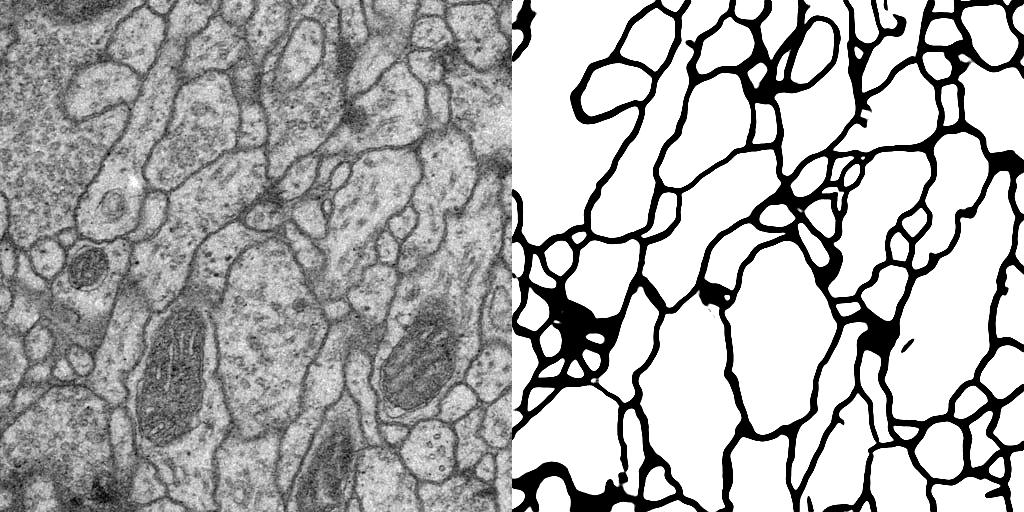

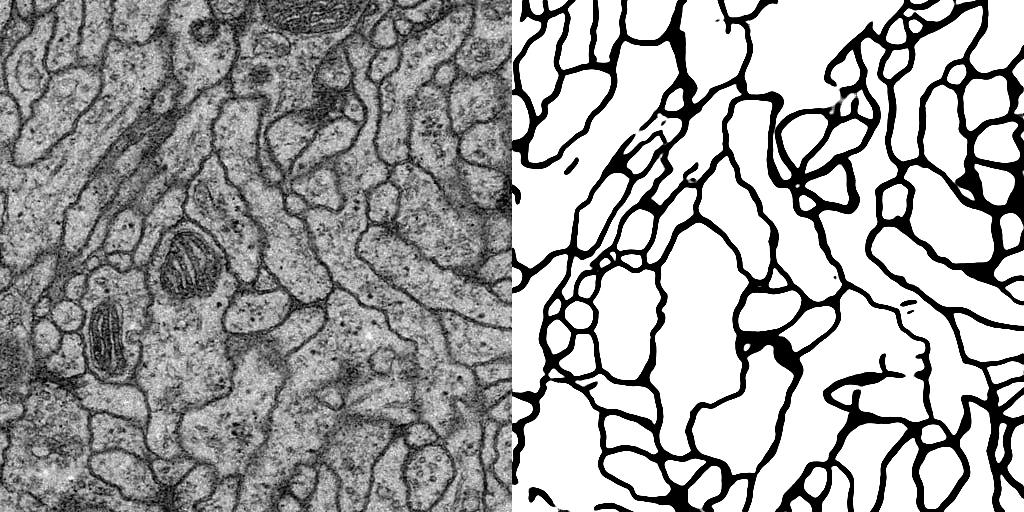

In [ ]:
def test(model, dataset, device):

    model.eval()
    for idx,(images) in enumerate(dataset):
      with torch.no_grad():
        images = images.to(device)
        #Forward Pass
        output = model(make_tensor(images))
        torch.clip(output, 0.0025, 0.9975)
        z = torch.cat((images,output), 3)
        # I am saving the images in my folder. You can save it wherever you wish
        save_image(z.clip(0, 1), f"/content/drive/MyDrive/U-Net_Train_Deformed/test-volume-labels/test-volume-labels-{idx+1}.jpg")

test(model, test_dataloader, device)

#**End Note**



Here you go! We have successfully segmented images of electron microscopic stalks with IOU score of around 95%. I have actually left out some of the parts of implementation from the paper like the weight map which they have used to give high weights to the border. You can experiment and try that for yourselves

Here's a list of things which you can try it out and experiment

1. You can implement the weight map like they have used in the paper. That by itself can surely increase the accuracy of the model. You could you use this to article to help you with implementing a weight map [link text](https://github.com/jaidevd/jaidevd.github.io/blob/source/blog/posts/weighted-loss-functions-for-instance-segmentation.ipynb)

2. You can maybe use a higher level of deformation by changing sigma and maybe play around a bit with that. Will deforming the image too much affect the accuracy?
